<a href="https://colab.research.google.com/github/Abhinavl3v3l/EVA6/blob/main/EVA6Session9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification on Cifar10 dataset.

In [1]:
!nvidia-smi

Sat Jul 10 03:12:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install albumentations==0.4.6 -q

In [3]:
import albumentations
albumentations.__version__

'0.4.6'

In [4]:
!git clone https://github.com/Abhinavl3v3l/EVA6.git
%cd "EVA6/s9"
!pwd

fatal: destination path 'EVA6' already exists and is not an empty directory.
/content/EVA6/s9
/content/EVA6/s9


## Necessary packages

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR 

import numpy as np
!pip install -U -q git+https://github.com/albu/albumentations --no-cache-dir
# print('Albumentations version:',albumentations.__version__)

In [6]:
from yadl.data.dataset import CIFAR10
from yadl.data.transform import albumentation_transform
from yadl.models import resnet, MixedResNet9
from yadl.utils.gradcam import gradcam, gradcam_utils
from yadl.utils.image_utilities import utils
from yadl.test import test
from yadl.train import train
from yadl.utils.lr_finder import LRFinder

## Visualize data

In [7]:
viz_data = CIFAR10.cifar10(root='./data', train=True, download=True, transform=None)
classes = viz_data.classes


Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
print("Classes of CIFAR10 dataset", classes)

Classes of CIFAR10 dataset ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
print(utils.dataset_calculate_mean_std())

Files already downloaded and verified
Files already downloaded and verified
([0.24697121432552785, 0.24338893940435022, 0.2615925905215076], [0.4918687788500817, 0.4826539051649305, 0.44717727749693625])


In [10]:
mean=[0.4919, 0.4827, 0.4472]
stddev=[0.2470, 0.2434, 0.2616]

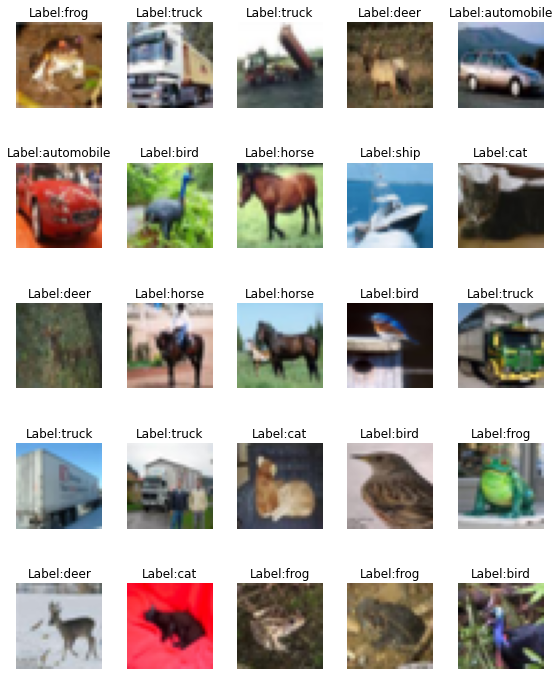

In [11]:
utils.visualize_data(viz_data,classes)

## Prepare dataset, apply transform and prepare Dataloader

In [12]:
train_transform = albumentation_transform(train=True, mean=mean, stddev=stddev)
test_transform = albumentation_transform(train=False, mean=mean, stddev=stddev)

In [13]:
train_dataset = CIFAR10.cifar10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10.cifar10(root='./data', train=False, download=True, transform=test_transform)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 133, 133])


(-0.5, 132.5, 132.5, -0.5)

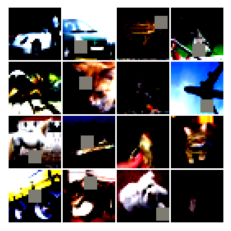

In [14]:
sample_images, sample_labels = next(iter(train_loader))
grid_image = torchvision.utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## Model

### Network model creation and summary

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
# model = resnet.ResNet18('LayerNorm').to(device)
model = MixedResNet9().to(device)
summary(model, input_size=(3, 32, 32))

Available device: cuda
MixedResnet model is now loaded.
Conv + Maxpool + BN + Relu every layer. Resnet blocks every alternate layer- 1st and 3rd layers.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNor

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Find optimum learning rate using LRFinder

MixedResnet model is now loaded.
Conv + Maxpool + BN + Relu every layer. Resnet blocks every alternate layer- 1st and 3rd layers.



Learning rate search finished. See the graph with {finder_name}.plot()
Best Loss observed at LR= 0.039317500000000005


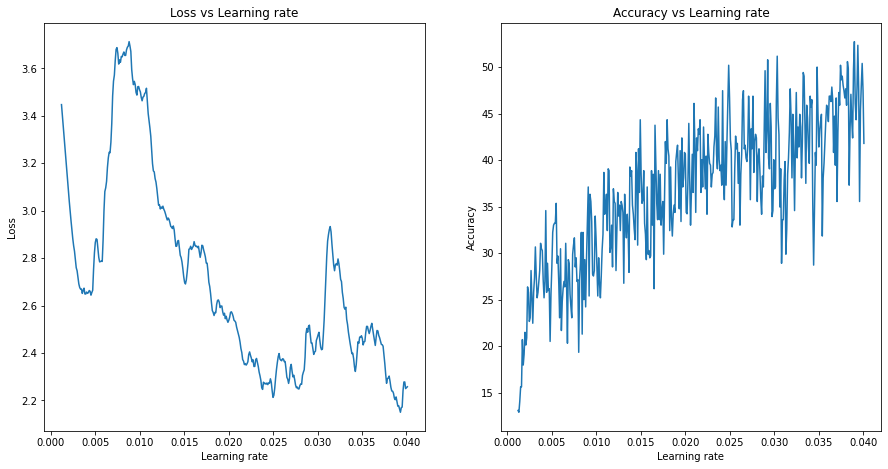

In [16]:
net = MixedResNet9().to(device)
criterion = nn.CrossEntropyLoss()
# Optimum LR for custom_model = 0.015
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=0.001)
lr_finder = LRFinder(net, optimizer, criterion, device)
#Run the range test
lr_finder.range_test(train_loader, end_lr=0.04, num_iter=400, step_mode="linear")
print("Best Loss observed at LR=",lr_finder.history['lr'][lr_finder.history['Loss'].index(lr_finder.best_loss)])
lr_finder.plot(skip_start=0, skip_end=0, log_lr=False)
lr_finder.reset()

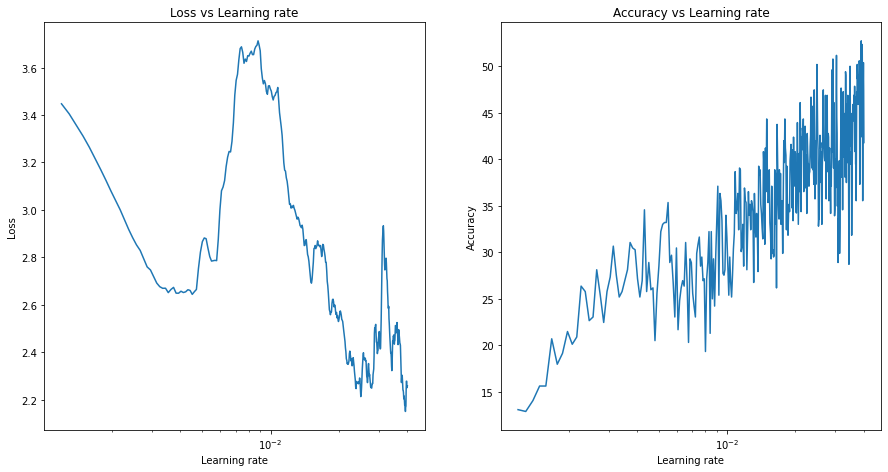

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5e7475950>,
      dtype=object)

In [17]:
lr_finder.plot(skip_start=0, skip_end=0, log_lr=True)

## Train model

In [18]:
EPOCHS = 24
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
l1_lambda=0
l2_lambda=0

# Optimization algorithm from torch.optim
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=l2_lambda)
# Loss condition
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr=0.02, total_steps=None, epochs=EPOCHS, steps_per_epoch=len(train_loader), pct_start=5/EPOCHS, 
                       base_momentum=0.85, max_momentum=0.95, div_factor=10, final_div_factor=1, last_epoch=-1)

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion, l1_lambda,scheduler)
    test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)
    # scheduler.step(test_loss_delta)

    train_accuracy.append(round(train_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_accuracy.append(round(test_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))

Epoch: 0
Train set: Epoch Accuracy: 40.6  Epoch Loss: 1.8784
Test set: Epoch Accuracy: 51.54  Epoch Loss: 1.4038
Epoch: 1
Train set: Epoch Accuracy: 56.83  Epoch Loss: 1.3306
Test set: Epoch Accuracy: 51.53  Epoch Loss: 1.6578
Epoch: 2
Train set: Epoch Accuracy: 61.27  Epoch Loss: 1.2917
Test set: Epoch Accuracy: 61.61  Epoch Loss: 1.3074
Epoch: 3
Train set: Epoch Accuracy: 69.12  Epoch Loss: 1.0026
Test set: Epoch Accuracy: 69.13  Epoch Loss: 1.188
Epoch: 4
Train set: Epoch Accuracy: 72.08  Epoch Loss: 0.9187
Test set: Epoch Accuracy: 73.13  Epoch Loss: 0.9061
Epoch: 5
Train set: Epoch Accuracy: 78.64  Epoch Loss: 0.6606
Test set: Epoch Accuracy: 79.36  Epoch Loss: 0.6336
Epoch: 6
Train set: Epoch Accuracy: 80.62  Epoch Loss: 0.6022
Test set: Epoch Accuracy: 76.55  Epoch Loss: 0.7622
Epoch: 7
Train set: Epoch Accuracy: 83.01  Epoch Loss: 0.5176
Test set: Epoch Accuracy: 79.53  Epoch Loss: 0.7211
Epoch: 8
Train set: Epoch Accuracy: 84.65  Epoch Loss: 0.4642
Test set: Epoch Accuracy: 84

## Results

### Train/Test accuracy and loss versus epochs

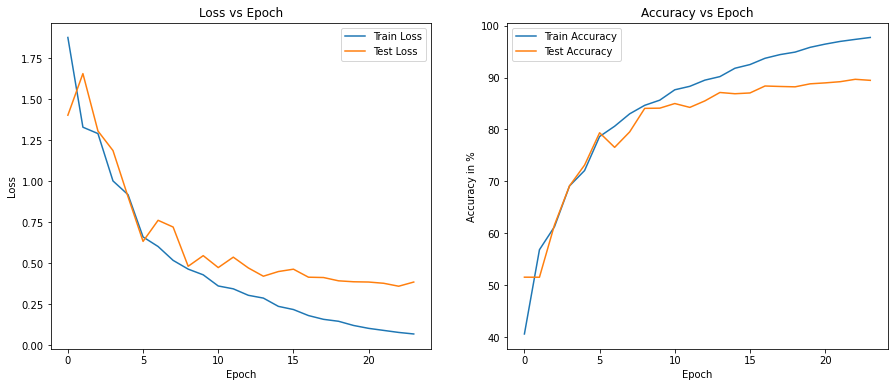

<Figure size 432x288 with 0 Axes>

In [19]:
utils.draw_loss_accuracy_graph(train_loss, test_loss, train_accuracy, test_accuracy)

### Misclassified Images

In [20]:
label_incorrect, prediction_incorrect, \
images_incorrect = utils.capture_incorrect_classified_samples(model, device, test_loader)

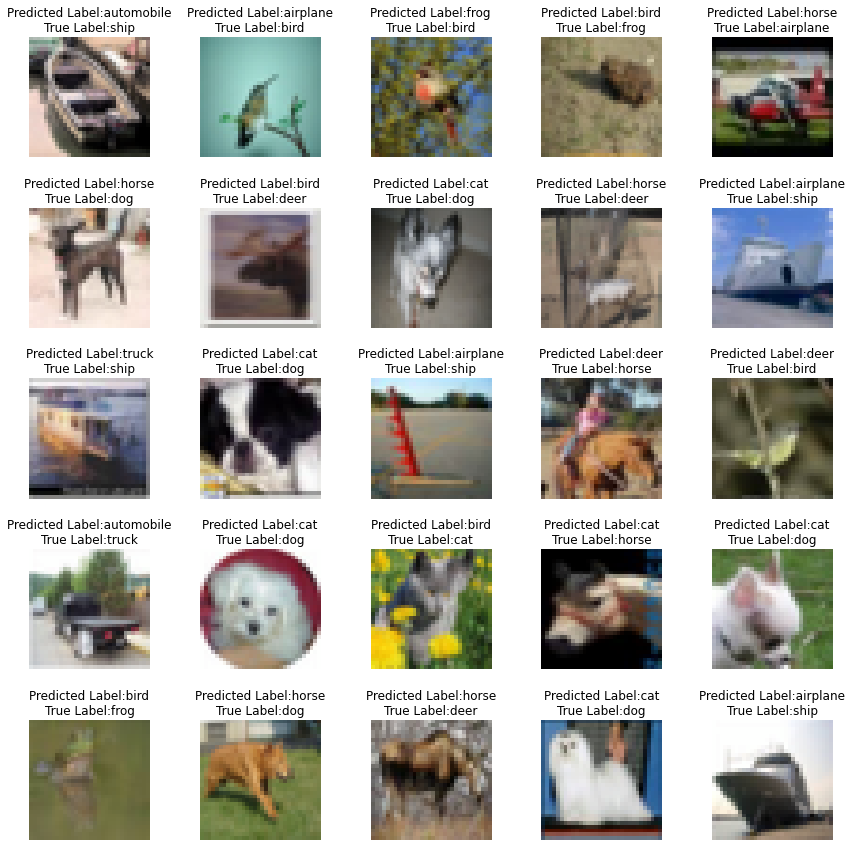

In [21]:
denormalized_images = utils.denormalize(images_incorrect, mean, stddev)
utils.show_incorrect_images(label_incorrect, prediction_incorrect, denormalized_images, classes)

## GradCAM on misclassified images

In [22]:
resnet_model_dict = dict(type='resnet', arch=model, layer_name='layer3', input_size=(32,32))
resnet_gradcam = gradcam.GradCAM(resnet_model_dict)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


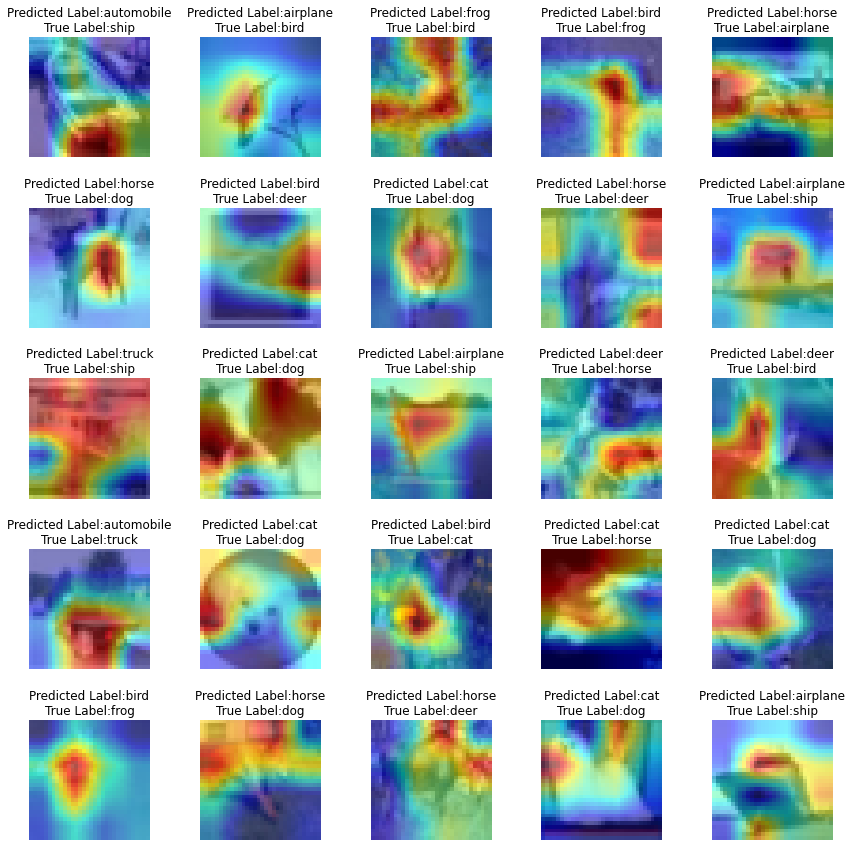

In [23]:
gradcam_utils.show_gradcam_images(resnet_gradcam, images_incorrect, label_incorrect, \
                    prediction_incorrect, classes, mean, stddev, device)